In [1]:
import pandas as pd
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import mysql_connection as mc
import statsmodels.api as sm

sns.set_style("white")

In [2]:
conn = mc.connect()

Please insert your password:········


Olist ran a Black Friday campaign on Nov. 24th 2017.

The Analytics team is tasked to evaluate its success. 

### Get weekly revenue data

In [3]:
revenue_query = """
SELECT 
    DATE_SUB(DATE(o.order_purchase_timestamp),
            INTERVAL DAYOFWEEK(DATE(o.order_purchase_timestamp)) - 1 DAY) AS week_id,
    SUM(oi.price)                                                         AS revenue
FROM orders o
    JOIN order_items oi
    ON o.order_id = oi.order_id
WHERE o.order_purchase_timestamp > '20170102'
    AND o.order_purchase_timestamp < '20180903'
    AND o.order_status = 'delivered'
GROUP BY week_id
ORDER BY week_id
"""

revenue = pd.read_sql(revenue_query, conn)

In [4]:
revenue.head()

,week_id,revenue
0,2017-01-01,2665.180000
1,2017-01-08,9219.869994
2,2017-01-15,21897.100027
3,2017-01-22,51331.669920
4,2017-01-29,66278.049820


In [5]:
revenue.dtypes

week_id     object
revenue    float64
dtype: object

In [6]:
revenue["week_id"] = pd.to_datetime(revenue["week_id"])

## Approach 1:

Compare week of Black Friday to time period before

In [7]:
week = revenue.copy()

In [8]:
week = week.loc[week["week_id"].between("2017-11-12","2017-11-19")]

In [9]:
week

,week_id,revenue
45,2017-11-12,174580.540058
46,2017-11-19,373838.420382


In [10]:
week.loc[week["week_id"] == "2017-11-12", "revenue"].values[0]

174580.54005765915

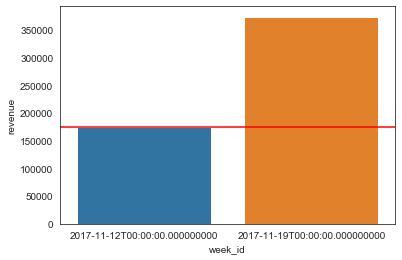

In [11]:
ax = sns.barplot(data=week,
                 x="week_id",
                 y="revenue");

ax.axhline(week.loc[week["week_id"] == "2017-11-12", "revenue"].values[0], color="r");

Calculate the difference

In [12]:
prev_week = week.loc[week["week_id"] == "2017-11-12", "revenue"].values[0]
bf_week = week.loc[week["week_id"] == "2017-11-19", "revenue"].values[0]

abs_diff = bf_week - prev_week
rel_diff = (bf_week / prev_week) - 1

In [13]:
print(f"""The revenue for the week including Black Friday increased by {round(rel_diff * 100, 2)}%
compared to the week prior. Assuming the Black Friday promtion accounts for the entire difference,
we were able to increase our revenue by {round(abs_diff, 2)} Rios""")

The revenue for the week including Black Friday increased by 114.14%
compared to the week prior. Assuming the Black Friday promtion accounts for the entire difference,
we were able to increase our revenue by 199257.88 Rios


We managed to increase our revenue due to Black Friday, according to our model. 
Our recommendation is to do it again!

---

Inspect the time-series to do visual analysis:

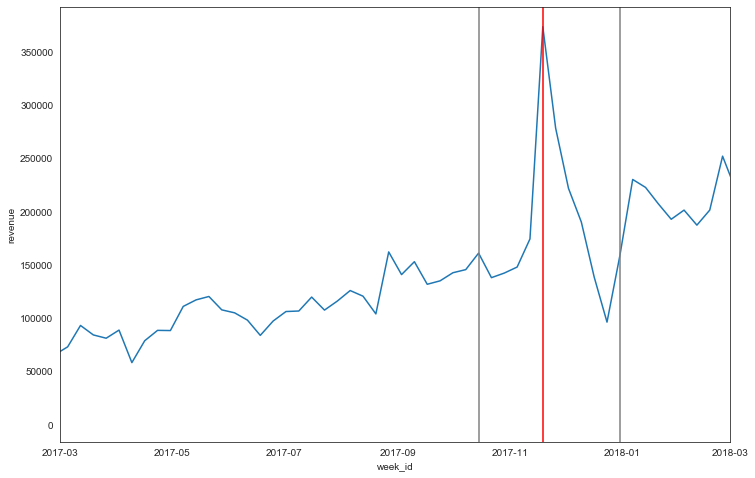

In [14]:
fig, ax = plt.subplots(figsize=(12,8))

sns.lineplot(data=revenue,
             x="week_id",
             y="revenue",
             ax=ax);

ax.axvline(pd.to_datetime("2017-11-19"), color="r");
ax.set_xlim((pd.to_datetime("2017-03-01"), pd.to_datetime("2018-03-01")));

ax.axvline(pd.to_datetime("2017-10-15"), color="grey");
ax.axvline(pd.to_datetime("2017-12-31"), color="grey");

The graph suggests that revenue decreased in some time periods immediatly before and after the week of Black Friday, which indicates that consumers may have changed their purchasing behavior. That is, some consumers may have preponed or postponed a purchase to save money. 
We can also see that revenue has probably been increasing throughout the year of 2017.


We can 'bake in' these additional assumptions through considering a time range instead of just the week affected (change in behavior) and through estimating a trend line (trend).

## Approach 2:

Establish baseline considering overall trend and change in behavior.

In [15]:
rev_trend = revenue.loc[revenue["week_id"].between("2017-03-01","2017-12-31")].copy().reset_index(drop=True)

In [16]:
rev_trend_train = rev_trend[rev_trend["week_id"].between("2017-03-01","2017-10-15")].copy().reset_index(drop=True)

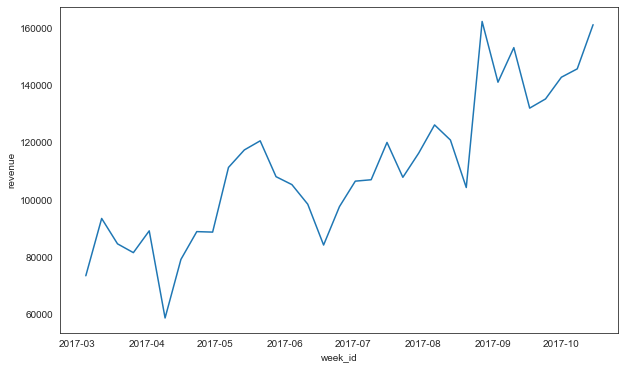

In [17]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_trend_train,
             x="week_id",
             y="revenue",
             ax=ax);

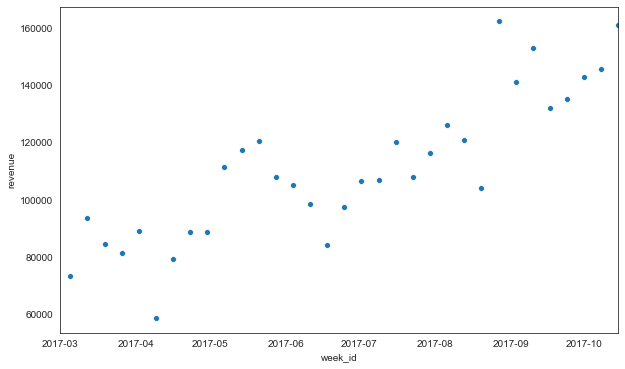

In [18]:
fig, ax = plt.subplots(figsize=(10,6))

sns.scatterplot(data=rev_trend_train,
                x="week_id",
                y="revenue",
                ax=ax);

ax.set_xlim((pd.to_datetime("2017-03-01"), pd.to_datetime("2017-10-15")));

Create time variable to run a regression

In [19]:
rev_trend_train = (rev_trend_train
                   .sort_values("week_id")
                   .assign(t=range(1, len(rev_trend_train) + 1)))

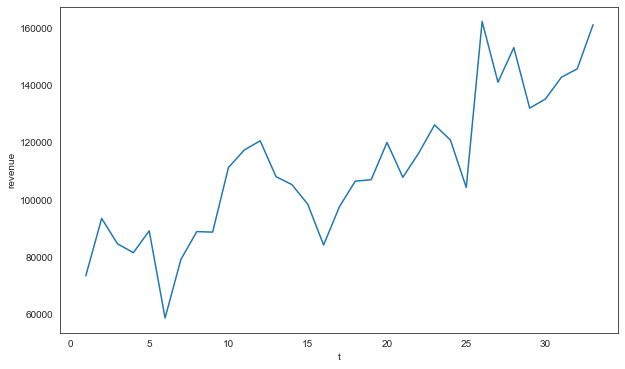

In [20]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_trend_train,
             x="t",
             y="revenue",
             ax=ax);

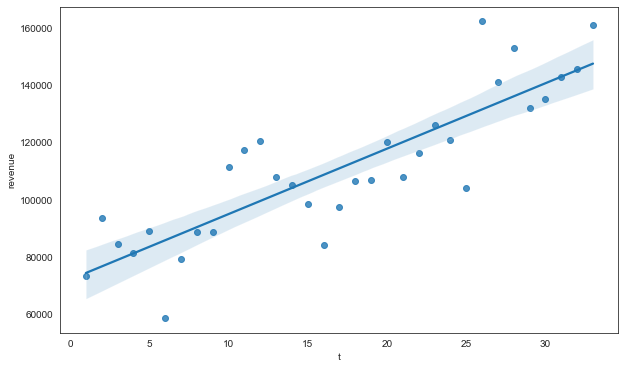

In [21]:
fig, ax = plt.subplots(figsize=(10,6))

sns.regplot(data=rev_trend_train,
            x="t",
            y="revenue",
            ax=ax);

Using Linear Regression to compute the fitted line

In [22]:
# add a constant
rev_trend_train = rev_trend_train.assign(const=1)

# rev_trend_train = sm.add_constant(rev_trend_train)

In [23]:
y = rev_trend_train["revenue"]
X = rev_trend_train[["const", "t"]]

lin_reg = sm.OLS(y, X)
results = lin_reg.fit()

In [24]:
results.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.733
Model:                            OLS   Adj. R-squared:                  0.724
Method:                 Least Squares   F-statistic:                     85.07
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           2.13e-10
Time:                        15:40:22   Log-Likelihood:                -359.88
No. Observations:                  33   AIC:                             723.8
Df Residuals:                      31   BIC:                             726.7
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.194e+04   4843.799     14.852      0.000    6.21e+04    8.18e+04
t           2292.7797    248.591      9.223      0.000    1785.776    2799.784
==============================================================================
Omnibus:                        0.224   Durbin-Watson:                   1.492
Prob(Omnibus):                  0.894   Jarque-Bera (JB):                0.040
Skew:                           0.081   Prob(JB):                        0.980
Kurtosis:                       2.947   Cond. No.                         40.0
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
"""

In [25]:
predicted_revenue = results.predict(X)
rev_trend_train = rev_trend_train.assign(predicted_revenue=predicted_revenue)

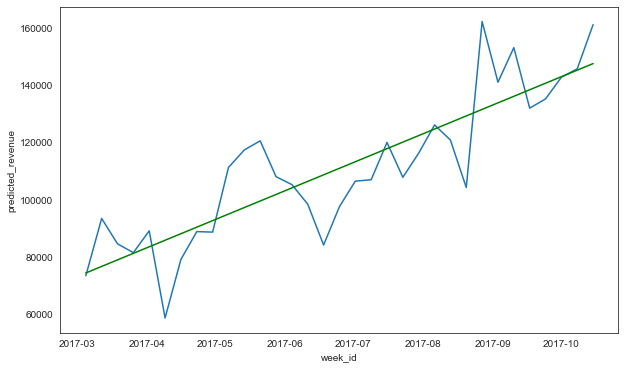

In [26]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_trend_train,
             x="week_id",
             y="revenue",
             ax=ax);

sns.lineplot(data=rev_trend_train,
             x="week_id",
             y="predicted_revenue",
             color="green",
             ax=ax);

Predict the revenue for the time periods affected by Black Friday

In [27]:
# add constant and time variable to rev_trend
rev_trend = (rev_trend.assign(const=1,
                              t=range(1, len(rev_trend) + 1)))

In [28]:
predicted_revenue_bf = results.predict(rev_trend[["const", "t"]])
rev_trend = rev_trend.assign(predicted_revenue=predicted_revenue_bf)

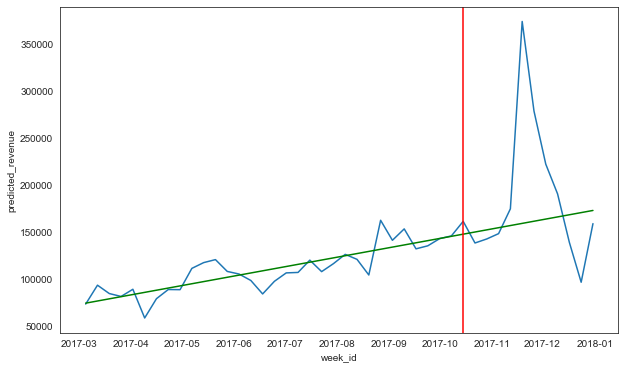

In [29]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_trend,
             x="week_id",
             y="revenue",
             ax=ax);

sns.lineplot(data=rev_trend,
             x="week_id",
             y="predicted_revenue",
             color="green",
             ax=ax);

ax.axvline(pd.to_datetime("2017-10-15"), color="red");

Calculate the differences betwen realized revenue and predicted revenue (baseline) and compute the sum

In [30]:
rev_bf = rev_trend.loc[rev_trend["week_id"] > '2017-10-15']

In [31]:
rev_bf = rev_bf.assign(diff=rev_bf["revenue"] - rev_bf["predicted_revenue"])

In [32]:
rev_bf

,week_id,revenue,const,t,predicted_revenue,diff
33,2017-10-22,138215.120121,1,34,149896.575500,-11681.455379
34,2017-10-29,142517.870461,1,35,152189.355219,-9671.484758
35,2017-11-05,148169.000426,1,36,154482.134939,-6313.134513
36,2017-11-12,174580.540058,1,37,156774.914659,17805.625399
37,2017-11-19,373838.420382,1,38,159067.694379,214770.726003
38,2017-11-26,278597.099682,1,39,161360.474099,117236.625583
39,2017-12-03,222071.810027,1,40,163653.253819,58418.556209
40,2017-12-10,190441.949685,1,41,165946.033538,24495.916146
41,2017-12-17,138845.850016,1,42,168238.813258,-29392.963243
42,2017-12-24,96475.050198,1,43,170531.592978,-74056.542780


In [34]:
abs_diff_trend = rev_bf["diff"].sum()
rel_diff_trend = (rev_bf["revenue"].sum() / rev_bf["predicted_revenue"].sum()) - 1

In [35]:
len(rev_bf)

11

In [36]:
print(f"""The increased revenue due to Black Friday increased by {round(rel_diff_trend * 100, 2)}%
for the duration of approx. {len(rev_bf)} weeks that we considered as impacted by our promotion.
Assuming the Black Friday promtion accounts for the entire difference,
we were able to increase our revenue by {round(abs_diff_trend, 2)} Rios.""")

The increased revenue due to Black Friday increased by 16.2%
for the duration of approx. 11 weeks that we considered as impacted by our promotion.
Assuming the Black Friday promtion accounts for the entire difference,
we were able to increase our revenue by 287594.84 Rios.


## Approach 3:

Establish baseline considering overall quadratic trend and change in behavior.

In [40]:
rev_qtrend_train = rev_trend_train[["week_id", "revenue", "const", "t"]].copy()
rev_qtrend = rev_trend[["week_id", "revenue", "const", "t"]].copy()

In [43]:
# add quadratic time variable
rev_qtrend_train = rev_qtrend_train.assign(t2=rev_qtrend_train["t"] * rev_qtrend_train["t"])

In [44]:
y = rev_qtrend_train["revenue"]
X = rev_qtrend_train[["const", "t", "t2"]]

In [45]:
quad_reg = sm.OLS(y, X)
results_q = quad_reg.fit()

In [46]:
results_q.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            OLS Regression Results                            
==============================================================================
Dep. Variable:                revenue   R-squared:                       0.746
Model:                            OLS   Adj. R-squared:                  0.729
Method:                 Least Squares   F-statistic:                     44.03
Date:                Mon, 20 Apr 2020   Prob (F-statistic):           1.19e-09
Time:                        15:43:28   Log-Likelihood:                -359.05
No. Observations:                  33   AIC:                             724.1
Df Residuals:                      30   BIC:                             728.6
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
==============================================================================
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const       7.906e+04   7490.432     10.554      0.000    6.38e+04    9.44e+04
t           1073.2721   1015.737      1.057      0.299   -1001.139    3147.683
t2            35.8679     28.982      1.238      0.225     -23.321      95.056
==============================================================================
Omnibus:                        1.022   Durbin-Watson:                   1.565
Prob(Omnibus):                  0.600   Jarque-Bera (JB):                0.358
Skew:                           0.225   Prob(JB):                        0.836
Kurtosis:                       3.239   Cond. No.                     1.63e+03
==============================================================================

Warnings:
[1] Standard Errors assume that the covariance matrix of the errors is correctly specified.
[2] The condition number is large, 1.63e+03. This might indicate that there are
strong multicollinearity or other numerical problems.
"""

In [49]:
results_q.predict(X)

0      80164.999212
1      81345.874970
2      82598.486466
3      83922.833703
4      85318.916678
5      86786.735394
6      88326.289849
7      89937.580043
8      91620.605977
9      93375.367650
10     95201.865063
11     97100.098216
12     99070.067108
13    101111.771739
14    103225.212110
15    105410.388221
16    107667.300071
17    109995.947660
18    112396.330990
19    114868.450058
20    117412.304866
21    120027.895414
22    122715.221701
23    125474.283728
24    128305.081494
25    131207.615000
26    134181.884245
27    137227.889230
28    140345.629954
29    143535.106418
30    146796.318622
31    150129.266564
32    153533.950247
dtype: float64

In [52]:
rev_qtrend = rev_qtrend.assign(t2=rev_qtrend["t"] * rev_qtrend["t"])

In [55]:
rev_qtrend = rev_qtrend.assign(predicted_revenue=results_q.predict(rev_qtrend[["const", "t", "t2"]]))

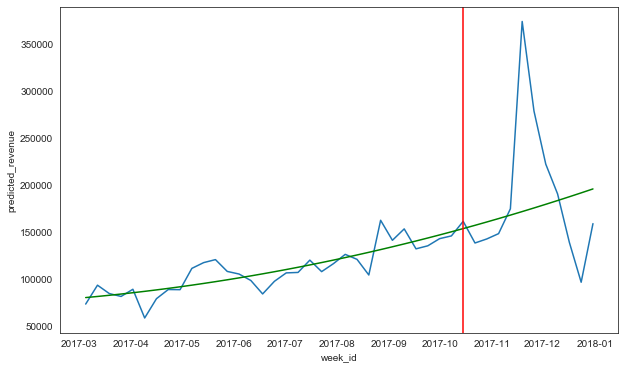

In [56]:
fig, ax = plt.subplots(figsize=(10,6))

sns.lineplot(data=rev_qtrend,
             x="week_id",
             y="revenue",
             ax=ax);

sns.lineplot(data=rev_qtrend,
             x="week_id",
             y="predicted_revenue",
             color="green",
             ax=ax);

ax.axvline(pd.to_datetime("2017-10-15"), color="red");

In [58]:
rev_trend

,week_id,revenue,const,t,predicted_revenue
0,2017-03-05,73254.889816,1,1,74234.844745
1,2017-03-12,93336.099724,1,2,76527.624465
2,2017-03-19,84442.799897,1,3,78820.404185
3,2017-03-26,81356.439932,1,4,81113.183905
4,2017-04-02,88992.920028,1,5,83405.963625
5,2017-04-09,58462.989766,1,6,85698.743344
6,2017-04-16,78988.539804,1,7,87991.523064
7,2017-04-23,88725.400124,1,8,90284.302784
8,2017-04-30,88554.129788,1,9,92577.082504
9,2017-05-07,111217.309701,1,10,94869.862224
